Com base nos dados do dataset desenvolvido no projeto inicial, que inclui informações sobre filmes como popularidade, pontuação de qualidade, ano de estreia, gênero, plataforma de streaming e avaliação de 5 estrelas, vamos construir um modelo de regressão para prever o valor do vote_average de filmes.

## Preparação do Ambiente e Carregamento dos Dados

In [68]:
!pip install mlflow

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import warnings

warnings.filterwarnings("ignore")

In [9]:
df = pd.read_csv('movies_data_treated.csv')
df.head()

,popularity,vote_count,vote_average,release_year_0,release_year_1,release_year_2,release_year_3,release_year_4,release_year_5,release_year_6,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,5_star_score
0,0.894890,0.452131,0.891304,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,4
1,0.874147,0.536778,0.586957,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,4
2,0.864918,0.121133,0.586957,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,4
3,0.858750,0.577933,0.630435,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4
4,0.853910,0.366025,0.673913,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4


## Separação dos dados

In [10]:
df.columns

Index(['popularity', 'vote_count', 'vote_average', 'release_year_0',
       'release_year_1', 'release_year_2', 'release_year_3', 'release_year_4',
       'release_year_5', 'release_year_6', 'release_year_7', 'release_year_8',
       'release_year_9', 'release_year_10', 'release_year_11',
       'release_year_12', 'release_year_13', 'Amazon Prime Video',
       'Disney Plus', 'Hulu', 'Max', 'Netflix', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       '5_star_score'],
      dtype='object')

No primeiro notebook, criamos a variável 5_star_score para representar a avaliação dos filmes em uma escala de 1 a 5. Agora, vamos aplicar o processo de one hot encoding para ajustar os valores dessa variável para uma escala de 0 a 1.

In [11]:
df_encoded = pd.get_dummies(df['5_star_score'], prefix='5_star')
df_encoded = df_encoded.astype(int)
df = pd.concat([df.reset_index(drop=True), df_encoded.reset_index(drop=True)], axis=1)
df.drop(columns=['5_star_score'], inplace=True)
df

,popularity,vote_count,vote_average,release_year_0,release_year_1,release_year_2,release_year_3,release_year_4,release_year_5,release_year_6,...,Romance,Science Fiction,TV Movie,Thriller,War,Western,5_star_2,5_star_3,5_star_4,5_star_5
0,0.894890,0.452131,0.891304,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0.874147,0.536778,0.586957,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2,0.864918,0.121133,0.586957,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.858750,0.577933,0.630435,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0.853910,0.366025,0.673913,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,0.045136,0.000584,0.543478,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10202,0.001424,0.000584,0.478261,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10203,0.053580,0.001168,0.652174,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10204,0.001195,0.001751,0.369565,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
X = df.drop(columns=['vote_average'])
y = df['vote_average']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Modelos analisados

Vamos analisar alguns modelos clássicos usados para problemas de regressão.

- KNN
- Gradient Boosting
- Random Forest
- SVR

Refinamos um processo para treinar os modelos que serão avaliados, ajustando os parâmetros para otimizar o desempenho com base nos dados específicos do problema. Dessa forma, avaliamos o desempenho dos modelos por meio das métricas: MSE, MAE e R2.


In [14]:
param_grids = {
    "RandomForest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.05],
            "max_depth": [3, 5, 7]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf", "poly"]
        }
    },
    "KNeighbors": {
        "model": KNeighborsRegressor(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"]
        }
    }
}

## Treinamento

Para identificar os parâmetros que maximizam o desempenho de cada modelo, utilizaremos o GridSearch. Esse método explora combinações possíveis de parâmetros, definidas em param_grid, para encontrar a configuração ideal.

In [15]:
mlflow.set_experiment("Movie_Vote_Average_Regression")

2024/07/11 22:46:47 INFO mlflow.tracking.fluent: Experiment with name 'Movie_Vote_Average_Regression' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/181302716125232231', creation_time=1720738007749, experiment_id='181302716125232231', last_update_time=1720738007749, lifecycle_stage='active', name='Movie_Vote_Average_Regression', tags={}>

In [16]:
for model_name, model_info in param_grids.items():
    model = model_info["model"]
    param_grid = model_info["params"]

    with mlflow.start_run(run_name=model_name):
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        y_pred = best_model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        mlflow.log_param("model", model_name)
        mlflow.log_params(best_params)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        mlflow.sklearn.log_model(best_model, "model")

        print(f"Model: {model_name}, Best Params: {best_params}, MSE: {mse}, MAE: {mae}, R2: {r2}")


Model: RandomForest, Best Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}, MSE: 0.009208060796759324, MAE: 0.07804747500769348, R2: 0.7370767204641797
Model: GradientBoosting, Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}, MSE: 0.008879337484187781, MAE: 0.07643146597050356, R2: 0.7464629542552952
Model: SVR, Best Params: {'C': 10, 'kernel': 'linear'}, MSE: 0.009356456287523763, MAE: 0.0790341329482046, R2: 0.7328394950633825
Model: KNeighbors, Best Params: {'n_neighbors': 9, 'weights': 'uniform'}, MSE: 0.011271522902482787, MAE: 0.0854433894164029, R2: 0.6781574500543187


In [17]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("Movie_Vote_Average_Regression")
runs = client.search_runs(experiment_ids=[experiment.experiment_id])

In [18]:
best_mse = float('inf')
best_model_uri = None
best_model_params = None

for run in runs:
    run_id = run.info.run_id
    run_name = run.data.tags.get("mlflow.runName")
    mse = run.data.metrics.get("mse")
    params = run.data.params
    print(f"Model: {run_name}, Run ID: {run_id}, Params: {params}, MSE: {mse}")

    if mse < best_mse:
        best_mse = mse
        best_model_uri = f"runs:/{run_id}/model"
        best_model_params = params

Model: KNeighbors, Run ID: 6551e5d6300a4b7ba050762198b2e490, Params: {'n_neighbors': '9', 'weights': 'uniform', 'model': 'KNeighbors'}, MSE: 0.011271522902482787
Model: SVR, Run ID: 3f0dae195d094a70a7074aaaf6e2b8cf, Params: {'kernel': 'linear', 'C': '10', 'model': 'SVR'}, MSE: 0.009356456287523763
Model: GradientBoosting, Run ID: d7933fbd5fc8402dbbbc865b5015e530, Params: {'max_depth': '3', 'learning_rate': '0.1', 'n_estimators': '200', 'model': 'GradientBoosting'}, MSE: 0.008879337484187781
Model: RandomForest, Run ID: d4d0b8f6fe4a4c609a38fdbf80ea2f3e, Params: {'max_depth': '10', 'n_estimators': '50', 'model': 'RandomForest', 'min_samples_split': '10'}, MSE: 0.009208060796759324


Pudemos observar que, nos dados de validação, o modelo que apresentou o melhor desempenho (menor MSE) foi o Gradient Boosting. Agora, iremos verificar como esse modelo se comporta em relação aos dados de teste, para avaliar sua capacidade de generalização e verificar se o comportamento é mantido.

## Teste dos modelos


Parâmetros do melhor modelo: {'max_depth': '3', 'learning_rate': '0.1', 'n_estimators': '200', 'model': 'GradientBoosting'}
Melhor MSE de validação: 0.008879337484187781
MSE no conjunto de teste: 0.009194455328590485
MAE no conjunto de teste: 0.07725478413274678
R2 no conjunto de teste: 0.7377901382763172


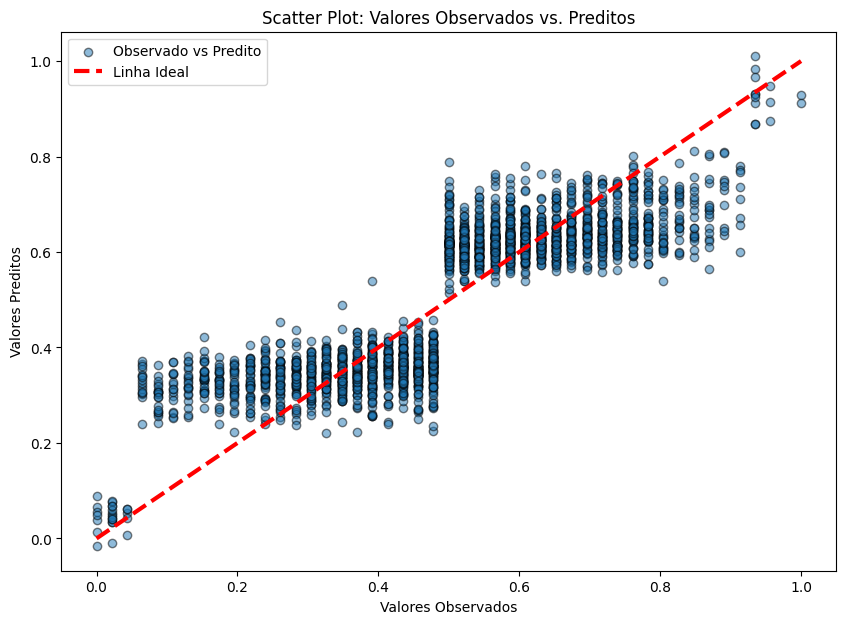

In [20]:
if best_model_uri:
    best_model = mlflow.sklearn.load_model(best_model_uri)

    y_test_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    print(f"Parâmetros do melhor modelo: {best_model_params}")
    print(f"Melhor MSE de validação: {best_mse}")
    print(f"MSE no conjunto de teste: {test_mse}")
    print(f"MAE no conjunto de teste: {test_mae}")
    print(f"R2 no conjunto de teste: {test_r2}")

    plt.figure(figsize=(10, 7))
    plt.scatter(y_test, y_test_pred, alpha=0.5, edgecolors='k', label='Observado vs Predito')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, label='Linha Ideal')
    plt.xlabel('Valores Observados')
    plt.ylabel('Valores Preditos')
    plt.title('Scatter Plot: Valores Observados vs. Preditos')
    plt.legend()
    plt.show()

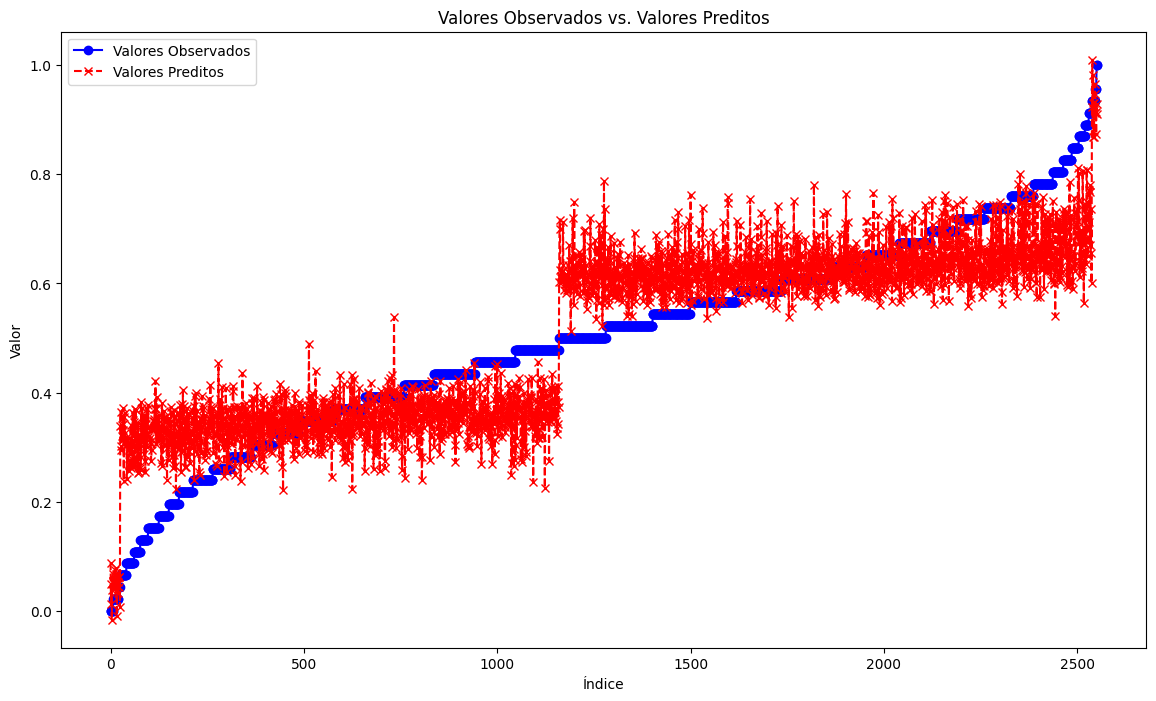

In [23]:
y_test = np.array(y_test)

sorted_indices = np.argsort(y_test)
sorted_y_test = y_test[sorted_indices]
sorted_y_test_pred = y_test_pred[sorted_indices]

# Cria o gráfico de linha
plt.figure(figsize=(14, 8))
plt.plot(sorted_y_test, label='Valores Observados', linestyle='-', marker='o', color='b')
plt.plot(sorted_y_test_pred, label='Valores Preditos', linestyle='--', marker='x', color='r')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores Observados vs. Valores Preditos')
plt.legend()
plt.show()

Durante os testes, notamos que o valor de MSE é baixo, porém a acurácia (R2) do modelo não é satisfatória, pois parece estar agrupando os dados em quatro partes distintas, limitando sua capacidade de generalização.

## Modelo Final

O modelo que apresentou o melhor desempenho foi o seguinte:

In [24]:
best_model_params

{'max_depth': '3',
 'learning_rate': '0.1',
 'n_estimators': '200',
 'model': 'GradientBoosting'}

Como ele apresentou um bom MSE, o nosso foco agora é aumentar o R2. Para isso, faremos alguns testes.

**Análise da correlação entre os dados**

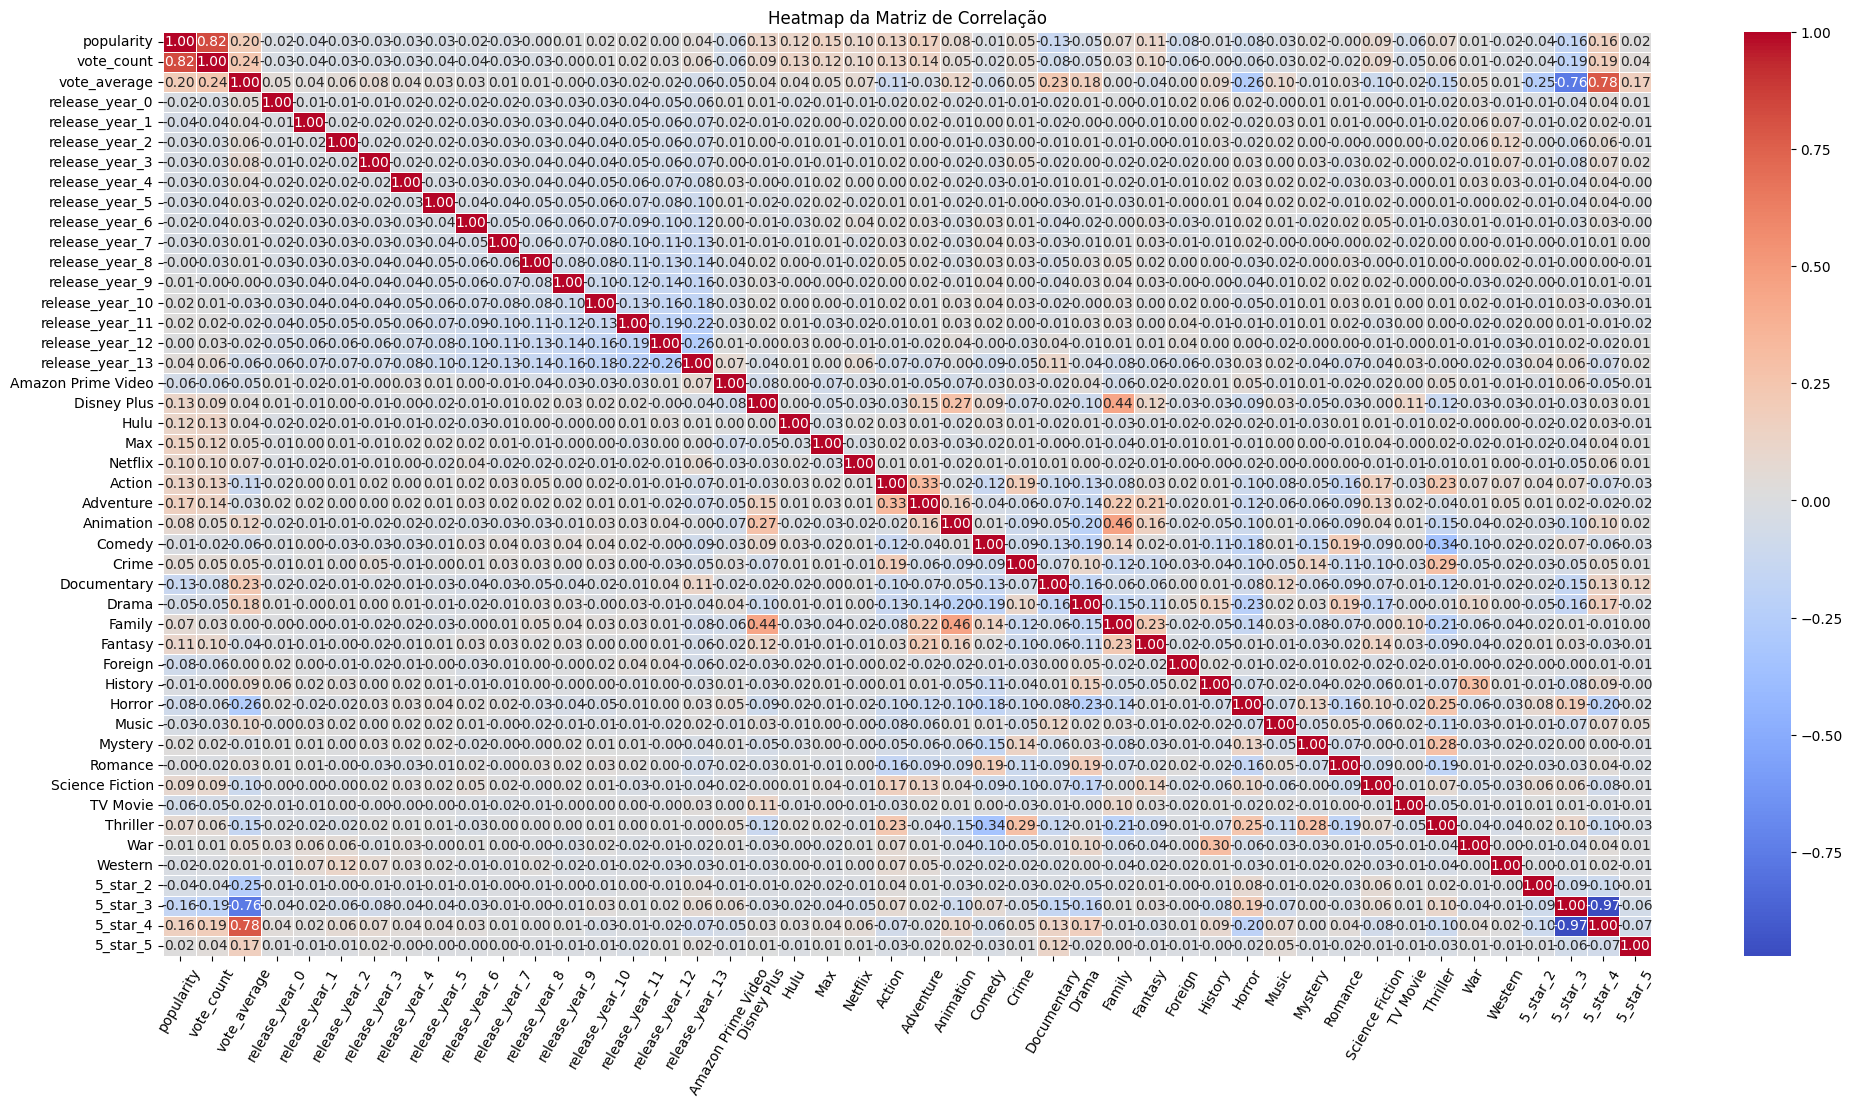

In [25]:
#Calcula a matriz de correlação
correlation_matrix = df.corr()

#Configura o tamanho da figura
plt.figure(figsize=(24, 12))

#Cria o heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

#Configura o título e os rótulos
plt.title('Heatmap da Matriz de Correlação')
plt.xticks(rotation=60)
plt.yticks(rotation=0)

#Mostra o heatmap
plt.show()

Ao analisar a correlação da variável target com as demais, observamos que as maiores correlações estão nas classes de 5_star, representadas por quatro colunas. Isso sugere que a formação de quatro grupos nos dados previstos é influenciada por essas relações. Portanto, vamos agora avaliar o desempenho do modelo sem essas colunas.

In [26]:
df.columns

Index(['popularity', 'vote_count', 'vote_average', 'release_year_0',
       'release_year_1', 'release_year_2', 'release_year_3', 'release_year_4',
       'release_year_5', 'release_year_6', 'release_year_7', 'release_year_8',
       'release_year_9', 'release_year_10', 'release_year_11',
       'release_year_12', 'release_year_13', 'Amazon Prime Video',
       'Disney Plus', 'Hulu', 'Max', 'Netflix', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       '5_star_2', '5_star_3', '5_star_4', '5_star_5'],
      dtype='object')

In [27]:
model1 = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=5)
model1.fit(X_train.drop(columns=['5_star_2', '5_star_3', '5_star_4', '5_star_5']), y_train)
model1.score(X_test.drop(columns=['5_star_2', '5_star_3', '5_star_4', '5_star_5']), y_test)

0.34666373061604083

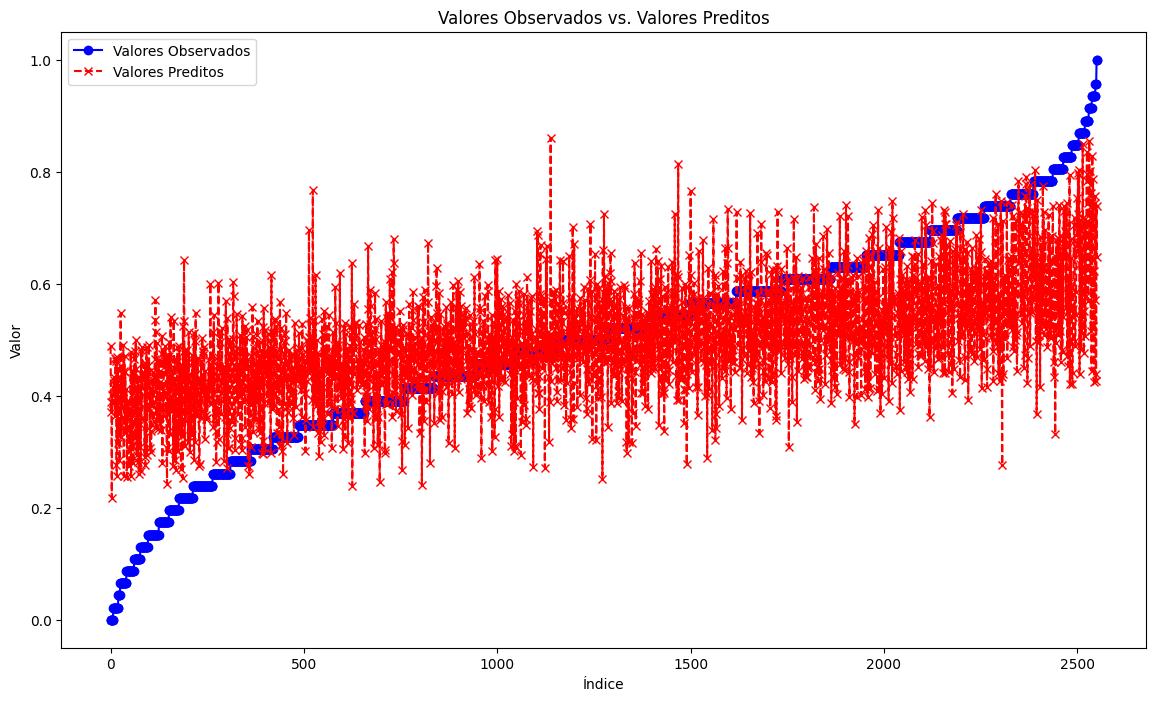

In [29]:
y_test = np.array(y_test)
y_pred = model1.predict(X_test.drop(columns=['5_star_2', '5_star_3', '5_star_4', '5_star_5']))
sorted_indices = np.argsort(y_test)
sorted_y_test = y_test[sorted_indices]
sorted_y_test_pred = y_pred[sorted_indices]

# Cria o gráfico de linha
plt.figure(figsize=(14, 8))
plt.plot(sorted_y_test, label='Valores Observados', linestyle='-', marker='o', color='b')
plt.plot(sorted_y_test_pred, label='Valores Preditos', linestyle='--', marker='x', color='r')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores Observados vs. Valores Preditos')
plt.legend()
plt.show()

Ao remover as colunas da variável 5_star_score nota-se que o agrupamento não ocorre mais, porém a acurácia decai muito. Logo, permaneceremos utilizando todas as colunas.

Vamos ajustar manualmente os parâmetros do modelo para tentar melhorar a acurácia. Para isso, iremos variar os valores de n_estimators, learning_rate e max_depth.

In [40]:
def train_and_test_model(n_estimators: int, learning_rate: float, max_depth: int):
  model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
  model.fit(X_train, y_train)
  print(model.score(X_test, y_test))

**Variação do n_estimators**

In [41]:
train_and_test_model(n_estimators=20, learning_rate=0.1, max_depth=5)

0.7177314105671979


In [42]:
train_and_test_model(n_estimators=70, learning_rate=0.1, max_depth=5)

0.7384267789694998


In [43]:
train_and_test_model(n_estimators=100, learning_rate=0.1, max_depth=5)

0.7385804114685035


In [44]:
train_and_test_model(n_estimators=200, learning_rate=0.1, max_depth=5)

0.733523383990591


In [45]:
train_and_test_model(n_estimators=150, learning_rate=0.1, max_depth=5)

0.7371802815538435


Observamos que o modelo alcança maior acurácia quando utiliza 100 estimadores. Portanto, vamos fixar esse valor para esse parâmetro.

**Variação do valor do learning_rate**

In [46]:
train_and_test_model(n_estimators=100, learning_rate=0.01, max_depth=5)

0.6242657453814655


In [47]:
train_and_test_model(n_estimators=100, learning_rate=0.2, max_depth=5)

0.7317825627912804


In [48]:
train_and_test_model(n_estimators=100, learning_rate=0.11, max_depth=5)

0.7377097170267624


In [49]:
train_and_test_model(n_estimators=100, learning_rate=0.07, max_depth=5)

0.739517922055146


In [55]:
train_and_test_model(n_estimators=100, learning_rate=0.08, max_depth=5)

0.7398985464457785


Observamos que o modelo alcança maior acurácia quando
 usa 0.08 de learning_rate. Portanto, vamos fixar esse valor para esse parâmetro.

**Variação do max_depth**

In [56]:
train_and_test_model(n_estimators=100, learning_rate=0.08, max_depth=10)

0.7159697525973717


In [57]:
train_and_test_model(n_estimators=100, learning_rate=0.08, max_depth=3)

0.7354282018830252


In [58]:
train_and_test_model(n_estimators=100, learning_rate=0.08, max_depth=6)

0.7390056492012124


In [59]:
train_and_test_model(n_estimators=100, learning_rate=0.08, max_depth=4)

0.739328156518923


Após variar o valor da profundidade máxima (max_depth), notamos que o valor original demonstra o melhor desempenho.

**Estrutura do modelo final**

In [61]:
train_and_test_model(n_estimators=100, learning_rate=0.08, max_depth=5)

0.739933879430048


In [62]:
final_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.08, max_depth=5)